# Algorithms blind tasting wines (Soon be finished)

*In this study we present a simple application of Natural Language Processing to classifying grape types based on semi-professional text based description of a glass of wine. We build a classifier model with pipelines and test it through two different datasets. A part of one of the datasets was involved through the building of the concept while the other is a completely out of sample data source. We present classification results of 4 different grape types with an accuracy above 85% which is in our view quite remarkable concerning the simplicity of the model.* 

**Important note: This is purely driven by sel-interest. None of the mentioned entities gave financial nor other type of support. Feel free to copy and distribute this work or give remarks or suggestions.**

Wine is one of the most popular alcohols that is being produced. Its production, selling and understanding has several thousands of years of expertise. A big industry has developed around producing the wine but also around describing it. The latter is very important since wine comes in different colour, taste, smell etc. It is important to describe these features of a bottle to customers because almost all of us enjoy different aspects of a glass of wine. The people who describe the wine are called wine experts or sommeliers [[1](#ch7)].

One has to be gifted with good genetics to be able to sense and identify numerous different smells and tastes and have enough lexical knowledge to map these features to his database of wine features. This way they can tell only from sampling a glass of wine what grape was used to make it, in which country was it made, what year and maybe some more. This is an amazing skill to have, but it requires years of practice (hopefully without getting drunk). There are schools, like the [Wine and Spirit Education Trust](https://www.wsetglobal.com/) [[2](#ch7)] where you can practice these skills and learn a framework to do blind tasting. They have their own terminology to describe certain wine features like: full-budied, oaky, dry, grassy etc. (see [[3](#ch7)] for a more complete list). 

Would it be possible to create an algorithm that can identify the grape, the country or the year (vintage) of a wine based on professional description of wines? We think it would be possible, but it is certainly not an easy task and has many conditions to perform it. The very first issue is to find a reliable, complete and professional description of ten thousands of wines (or even more). The second issue is to create a natural language processing (NLP) model that is capable of extracting the relevent information from the descriptions and put them into an input format that a machine can handle and understand. The final issue is to find a classifier that can read the input and based on a set of optimizable parameters it can correctly tell us the target feature (in this study it will be the grape type) of the corresponding wine description. 

In a previous study, called [Become a sommelier](https://diveki.github.io/projects/wine/wine.html) [[4](#ch7)], we explored the issue of collecting the data. We wrote a web scraping algorithm that collects wine descriptions from various online wine selling websites (please read that study for more details). This database contains roughly 2000 samples. These descriptions are more in a customer friendly style, rarely very detailed, in all together we could call them semi-professional descriptions, but written by experts. Later in our research we came accross a [Kaggle](https://www.kaggle.com/) [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews) [[5](#ch7)] by *zackthoutt*. He collected a similar database of wine descriptions from another source as we did and his database contains more than 100 thousand samples. This size of database starts to be in the usable range.

In another previous study, called [Application of TfIdf-vectorizer on wine data](https://diveki.github.io/projects/wine/tfidf.html) [[6](#ch7)] we established the concept of our model that extracts information from the wine description and turns it into a vectorized bag-of-words model. We used our own data set (and not the Kaggle one) to build up all the aspects of our model, that we will present here too, but for more details read the mentioned study. To make sure that our model do not get biased during the building process, we divided it into a train and a test set and we use the same concept here too. Basically we neglected any knowledge from the test set during the building process.

In this study we will combine the created NLP model with a classifier and test the model performance in different scenarios. We will show classification results on both databases separately and also show an example where the Kaggle database trains the constructed model and we test it on our database. We present hyperparameter optimization and kfold verification of the results too. 

This study will step through the following topics:

1. [Loading data](#ch1)
2. [Model definition](#ch2)
 
   2.1. [Stopwords](#ch2.1)

   2.2. [POS tagging and Lemmatizing](#ch2.2)
   
   2.3. [Label encoding](#ch2.3)
   
   2.4. [Splitting data into train and test sets](#ch2.4)
   
   2.5. [Defining selectors](#ch2.5)
   
   2.6. [Defining data pre-processors](#ch2.6)
   
   2.7. [Defining classiffiers](#ch2.7)
   
3. [Train and test the model](#ch3)

   3.1. [Analysis of train predictions](#ch3.1)
   
   3.2. [Analysis of test predictions](#ch3.2)
   
   3.3. [Testing with different classifiers](#ch3.3)

   3.4. [Hyperparameter tuning](#ch3.4)
   
4. [Classification of data from Kaggle](#ch4)

   4.1. [Data formatting](#ch4.1)
   
   4.2. [Classification](#ch4.2)
   
5. [Cross-data validation of the model](#ch5)
6. [Conclusion](#ch6)
7. [References](#ch7)


<a id="ch1"></a>
# 1. Loading data

We start by loading all the required packages and data to solve the above described task. Most of the details about these steps are described in [Become a sommelier](https://diveki.github.io/projects/wine/wine.html) and [Application of Tfidf-vectorizer on wine data](https://diveki.github.io/projects/wine/tfidf.html). 

We start by loading *pandas, numpy, re, scikit-learn* and *nltk* packages.

In [1]:
# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from string import punctuation

Then we load the wine data set that we scraped online. For the details about this data set see the Appendix of [Become a sommelier](https://diveki.github.io/projects/wine/wine.html). 

In [2]:
filename = '../DataBase/5_grape_db.xlsx'

a0 = pd.read_excel(filename)
a0.head()

,abv,colour,country,description,grape_variety,name,Body
0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light
1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium
2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium
3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium
4,13.5,red,Argentina,this wine has concentrated aromas and flavours...,cabernet sauvignon,Argento Cabernet Sauvignon 2014,full


This data set contains all kinds of information about 5 grape types. We will use only 4 of the grape types, since the 5th does not have many samples. These 4 types are: *pinot noir, syrah* (red wines) and *chardonnay, sauvignon blanc* (white wines). By setting a limit to the minimum sample size we filter the input data.

In [3]:
result = a0['grape_variety']
limit = 40
## removing varieties that have only one member in the database
counts = nltk.Counter(result)
varieties = [key for key in counts if counts[key] > limit]
data_input = a0[a0['grape_variety'].isin(varieties)].reset_index()

In [4]:
data_input.head()

,index,abv,colour,country,description,grape_variety,name,Body
0,0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light
1,1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium
2,2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium
3,3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium
4,5,13.0,white,Argentina,this lightly oaked wine offers aromas of ripe ...,chardonnay,Argento Chardonnay 2015,medium


From this dataframe we will only use some of the features. The columns description and colour are the most important ones, but in the our first implementation we will add the Body feature as an input too. Let us see an example what does the code face in the descripiton column and extract reliable information in order to be able to classify grape types.

In [5]:
data_input.loc[1, 'description']

'a delicate, floral wine with soft cherry and strawberry flavours. medium-bodied, fresh and bright, with smooth supple tannins and a savoury, spicy chocolate finish. an 8-hour-long maceration period, followed by cold-settling racked fresh from the press. lees stirring to increase texture. 35-day-long fermentation period at an average temperature of 9-12c.'

<a id="ch2"></a>
# 2. Model definition

As we showed in [Application of Tfidf-vectorizer on wine data](https://diveki.github.io/projects/wine/tfidf.html) in order to classify the grape types correctly, the processed input data for one grape should not correlate with other grape types. The applied model has to minimize this correlation. We did not perform an exact optimization process but rather added newer features to the model step-by-step and investigated what happens with the correlation. All the features presented here are the result of the mentioned study, so for details please go and read it. Some of the steps presented below are not discussed in that study, therefore we will elaborate them more. 

Our model will be a very simple vectorized 1-gramm bag-of-words model. We will rely on term frequency - inverse document frequency (tf-idf) vectorization and some additional noise filters and word processors.

<a id="ch2.1"></a>
## 2.1. Stopwords

As you can see above, there are words in the description column that are certainly not adding any information about the grape type, like *with, and, by* etc. We can collect a list of these kind of words and call them stopwords. These will be filtered out from the text and not taken into account in the classification process. We will exploit the *nltk* package's stopwords and extend it with some words and punctuations defined by us.

In [6]:
# defining stopwords: using the one that comes with nltk + appending it with words seen from the above evaluation
stop_words = stopwords.words('english')
stop_append = ['.', ',', '`', '"', "'", '!', ';', 'wine', 'fruit', '%', 'flavour', 'aromas', 'palate']
stop_words1 = frozenset(stop_words + stop_append)

<a id="ch2.2"></a>
## 2.2. POS tagging and Lemmatizing

The text we want to analyse may contain the same word in different forms. A very simple example would be *cherry* and *cherries* the singular and plural version of the same word. Another example could be *good* and *better*. In their original form, these words are treated as separete ones by the code. To bring them to their common form we apply [lemmatization](https://en.wikipedia.org/wiki/Lemmatisation) [[7](#ch7)]. This is a very difficult task since it requires correct identification of the word (noun, verb etc.) type in the context. The latter is position tagging or POS tagging. We use *nltk*'s pos tagger, but as any other tagger this is not perfect neither. 

The most information of a wine description is carried in its nouns and adjectives. Verbs and adverbs are rather common words to most of the wines. In our model we apply a filter that leaves nouns and adjectives in the text and removes anything else. 

The POS tagging, lemmatizing and type selecting is carried out by the *LemmaTokenizer* class.

In [7]:
# list of word types (nouns and adjectives) to leave in the text
defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN
    
# lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

<a id="ch2.3"></a>
## 2.3. Label encoding

Although, we are mainly interested in classification by using text based description, from the database we can see that there are other, possible helpful features of the wine, that can help to classify. Such features are *body* and *colour*. Both of them are used by sommeliers to describe a wine. Colour can be easily observed while body is reflecting in a way the acidity of a wine. 

These columns in the database are defined in text format, so we have to turn them into numbers so that the computer can understand them. Both of these features have discreate value, so we could just easily attach a number to them like: *red=1*, *rose=2*, *white=3*. This is called [label encoding](https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621) [[8](#ch7)]. This would not be a disastrous approach, but the classifier might think there there is a trend like tendency between these categories (because of the increase in numbers), which is obviously false. Instead, sticking to the case of colours, we create three more columns (there are three colours), each representing one colour. Each column can take two values, 0 (if the wine does not have that feature) and 1 (if the wine has that feature). We do this for both the body and colour columns with the *pandas* get_dummies method.

The following cell prints an example of the modified data set that contains the encoded labels.

In [8]:
body_dummies = pd.get_dummies(data_input['Body'])       # label encoding the Body column
colour_dummies = pd.get_dummies(data_input['colour'])   # label encoding the colour column
# adding the body labels to the original dataset
data_input = data_input.merge(body_dummies, left_index=True, right_index=True)
# adding the colour labels to the original dataset
data_input = data_input.merge(colour_dummies, left_index=True, right_index=True)
data_input.head()

,index,abv,colour,country,description,grape_variety,name,Body,dry,full,light,medium,red,rose,white
0,0,13.5,red,USA,this wine has concentrated depth and purity of...,pinot noir,A to Z Pinot Noir 2014,light,0,0,1,0,1,0,0
1,1,13.5,red,Argentina,"a delicate, floral wine with soft cherry and s...",pinot noir,Alamos Seleccion Pinot Noir 2016,medium,0,0,0,1,1,0,0
2,2,12.5,red,Italy,"a medium-bodied wine, with aromas and flavours...",pinot noir,Alois Lageder Alto Adige Pinot Noir 2014,medium,0,0,0,1,1,0,0
3,3,13.5,white,Italy,very fresh aromas and flavours of gooseberry a...,sauvignon blanc,Alois Lageder Terlaner Sauvignon Blanc 2016,medium,0,0,0,1,0,0,1
4,5,13.0,white,Argentina,this lightly oaked wine offers aromas of ripe ...,chardonnay,Argento Chardonnay 2015,medium,0,0,0,1,0,0,1


<a id="ch2.4"></a>
## 2.4. Splitting data into train and test sets

As we have already mentioned the analysis in [4,6](#ch7) were performed on a preselected train dataset from the whole database. We will use exactly the same train dataset to train our model. This is easy to do by setting the *random_state* argument to the same value as it was in those studies. Also, we only select the columns of description, labelled colours and labelled bodies. The *train_test_split* function will create train and test features and targets.

In [9]:
# split the data into train and test
combined_features = ['Body', 'description', 'full', 'light', 'medium', 'dry', 'red', 'rose', 'white']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(data_input[combined_features], data_input[target], 
                                                    test_size=0.33, random_state=42)

In [10]:
X_train.head()

,Body,description,full,light,medium,dry,red,rose,white
229,medium,as seen on tv.the belen estate in chile 's cas...,0,0,1,0,1,0,0
257,dry,"this classic displays elements of gooseberry ,...",0,0,0,1,0,0,1
260,dry,' quest to create an australian rival to the t...,0,0,0,1,0,0,1
210,full,are dedicated to showcasing the wide range of ...,1,0,0,0,1,0,0
193,dry,made from a of the best grapes grown throughou...,0,0,0,1,0,0,1


In [11]:
y_train.head()

229         pinot noir
257    sauvignon blanc
260         chardonnay
210              syrah
193    sauvignon blanc
Name: grape_variety, dtype: object

<a id="ch2.5"></a>
## 2.5. Defining selectors

We will build up a [pipeline](https://medium.com/@yanhann10/a-brief-view-of-machine-learning-pipeline-in-python-5f50b941fca8) for this study. In a pipeline we chain together all kind of actions on the data into one stable flow. For example it combines data transformers (numerical normaliser) with data estimators (Naive Bayes classifier).

The input data has both text based and numerical features. They cannot be processed together by the classifier unless they are transformed into the same format, in this case numerical format. We aim to construct a pipeline that takes care of all these issues. 

We define two classes where one of them will select the text based column from the input, the other will select the numerical input.

In [12]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

<a id="ch2.6"></a>
## 2.6. Defining data pre-processors and pipelines

As mentioned before, text based data cannot be used by the classifier. Therefore, we create a vectorizer that takes a string input and turns it into a vector of numbers. 

We will use the [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) with 1-grams of words, the predifined stopwords and LemmaTokenizer as helping tools. Tf-idf applies the bag-of-words concept, which creates a vocabulary (list of all the terms from the string) and maps a value to them. In the case of tf-idf this value is roughly the product of the term frequency (the number of times a term occured within the document string) and the inverse document frequency (the inverse of the the number of documents that this term is present). Basically, the first term emphasizes the terms that are frequent in one document while weighs down the terms that are frequent over several documents. The reason for the latter is that if a word is used in many documents it is unlikely that it has characteristic meaning to one topic. For more on this read the relevant sections in [Application of Tfidf-vectorizer on wine data](https://diveki.github.io/projects/wine/tfidf.html).

Let us define the vectorizer.

In [13]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words, analyzer='word', 
                                               norm='l2', tokenizer=LemmaTokenizer())

Now let us combine the text vectorizer with the text selector into one pipeline.

In [14]:
text = Pipeline([
                ('selector', TextSelector(key='description')),
                ('vectorizer', vec_tdidf)
                ])

Just as in the previous sell let us put the numeric selectors into pipelines too.

In [15]:
# pipelines of body features
full = Pipeline([
                ('selector', NumberSelector(key='full')),
                ])
medium = Pipeline([
                ('selector', NumberSelector(key='medium')),
                ])
light = Pipeline([
                ('selector', NumberSelector(key='light')),
                ])
dry = Pipeline([
                ('selector', NumberSelector(key='dry')),
                ])

#pipelines of colour features
red = Pipeline([
                ('selector', NumberSelector(key='red')),
                ])
rose = Pipeline([
                ('selector', NumberSelector(key='rose')),
                ])
white = Pipeline([
                ('selector', NumberSelector(key='white')),
                ])

Finally let us combine all these pipelines. Note, that to combine different features one has to use the [FeatureUnion](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html) class. Now we have all methods of transformation and pre-processing put into one variable.

In [16]:
feats = FeatureUnion([('full', full),
                      ('medium', medium),
                      ('light', light),
                      ('dry', dry),
                      ('description', text),
                      ('red', red),
                      ('rose', rose),
                      ('white', white)
                      ])


<a id="ch2.7"></a>
## 2.7. Defining classiffiers

The last step in our pipeline is to define a classifier. Our first choice of classifier is the [Random Forest](https://en.wikipedia.org/wiki/Random_forest). It is an ensemble classifier of decision trees and it tends to be more accurate than a single decision tree classifier. It is very versatile in application and fit to determine which features are giving the most contribution to good prediction (although we will not use this feature here). 

In [41]:
clf = RandomForestClassifier(random_state=42)

Now let us put this classifier in the pipeline to combine it with the feature union and then we are ready to go and do blind tasting.

In [42]:
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])    

<a id="ch3"></a>
# 3. Train and test the model

We have arrived to the point where we can train our model with the train data set. To do that we call the *fit* method of the *pipe* object. Since this database is not really big, this training does not take a lot of time, while you should keep in mind if you have millions of inputs, your training might take a considerable amount of time.

In [43]:
%timeit pipe.fit(X_train, y_train)

1.12 s ± 80.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


With the `%timeit` magic command you can measure how long does it take to run one line of code. In this case it took about 1 second to run it. 

<a id="ch3.1"></a>
## 3.1. Analysis of train predictions

Now let us see the performance of this trained model. Let us first investigate how good the model is at classifying grape types in the train data set. This is actually a completely in-sample measurement. We expect it to be good.

We define a function to print out all kinds of statistics on the performance, since we will use this a lot.

In [53]:
def print_stats(preds, target, labels, sep='-', sep_len=40):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)
    


We will print out the [accuracy](http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score), the [classification report](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-report) and the [confusion matrix](http://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix). 

Accuracy is the number of correctly predicted grape types divided by the total number of grapes. 

Classification report is a concise way of presenting estimator performance through the following metrics: [precision](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html), [recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html), [f1-score](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) and the number of samples belonging to each target feature. A good classifier has a value close to 1 for both precision and recall and therefore for f1-score too.

Confusion matrix is again a simple way to present how many grape types were correctly identified (diagonal elements), while the off diagonal elemnts tell us how many samples were classified into another target type. Obviously, one would like to decrease the values of the off diagonal elements to get perfect classification. The vertical axis represents the true class of the target, why the horizontal axis shows the predicted value of the target.

Accuracy = 1.000
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       1.00      1.00      1.00        58
     pinot noir       1.00      1.00      1.00        40
sauvignon blanc       1.00      1.00      1.00        55
          syrah       1.00      1.00      1.00        27

    avg / total       1.00      1.00      1.00       180

----------------------------------------
Confusion matrix


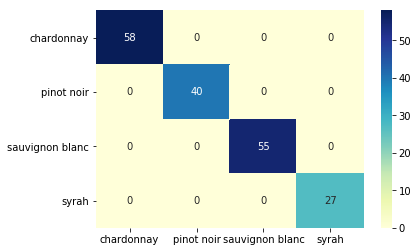

In [54]:
#train stats
preds = pipe.predict(X_train)
print_stats(preds, y_train, pipe.classes_)

Well this model does a perfect job on the train data set. We kind of expect it to do, since it was trained on it. However we are still amazed that the vectorization of the text combined with body and colour description is capable to perfectly differentiate all the train input grape types. Let us turn now to the test set.

<a id="ch3.2"></a>
## 3.2. Analysis of test predictions

As we have mentioned earlier, this test data was never used with respect to the model. It is the first time that the model sees it. The target sample sizes are not big.

Accuracy = 0.744
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.97      0.71      0.82        45
     pinot noir       0.89      0.68      0.77        25
sauvignon blanc       0.48      0.83      0.61        12
          syrah       0.47      1.00      0.64         8

    avg / total       0.84      0.74      0.76        90

----------------------------------------
Confusion matrix


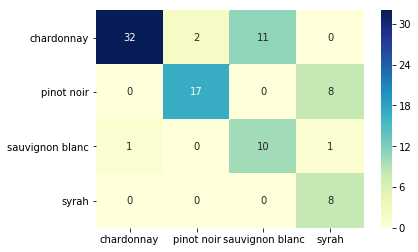

In [55]:
# test stats
preds = pipe.predict(X_test)
print_stats(y_test, preds, pipe.classes_)

The accuracy is 74%. We have expected to have false positive and false negative scores, but a surprising observation is that even though we explicitly tell the classifier what colour the wine has it is still able to confuse red with white wines and vice versa. In order to decide wether this result is rather good or bad, we establish a benchmark and also try out other classifiers.

<a id="ch3.3"></a>
## 3.3. Testing with different classifiers

First, we establish a reference classification outcome. We do it by creating a classifier that generates random predictions by respecting the training set target feature distribution (since not all the grape types are equally represented).

1.06 s ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy = 0.289
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.42      0.50      0.46        28
     pinot noir       0.16      0.14      0.15        22
sauvignon blanc       0.29      0.19      0.23        31
          syrah       0.18      0.33      0.23         9

    avg / total       0.29      0.29      0.28        90

----------------------------------------
Confusion matrix


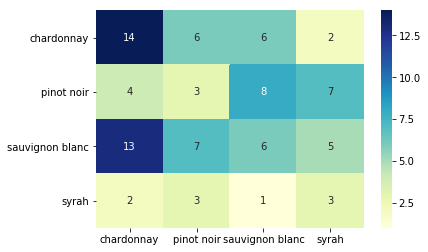

In [56]:
clf = DummyClassifier(strategy='stratified',random_state=42)
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])
%timeit pipe.fit(X_train, y_train)
# test stats
preds = pipe.predict(X_test)
print_stats(y_test, preds, pipe.classes_)

Well a random stratified classifier achieves 29% accuracy. Our first try with the Random Forest classifier was clearly way better. Now let us look at one of the most used ensemble booster classifier, the XGBClassifier from [xgboost](https://xgboost.readthedocs.io/en/latest/python/python_api.html) package. Gradient boosting sequentially adds predictors and corrects previous models. The classifier fits the new model to new residuals of the previous prediction and then minimizes the loss when adding the latest prediction.

1.32 s ± 98.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Accuracy = 0.822
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.91      0.79      0.85        38
     pinot noir       0.79      0.83      0.81        18
sauvignon blanc       0.71      0.83      0.77        18
          syrah       0.82      0.88      0.85        16

    avg / total       0.83      0.82      0.82        90

----------------------------------------
Confusion matrix


/home/diveki/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


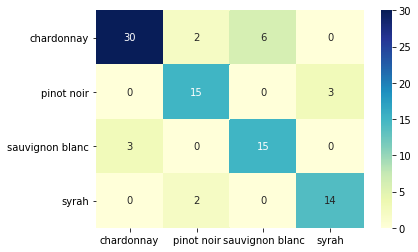

In [57]:
clf = XGBClassifier(random_state=42, n_jobs=3)
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])
%timeit pipe.fit(X_train, y_train)
# test stats
preds = pipe.predict(X_test)
print_stats(y_test, preds, pipe.classes_)

Without any adjustment it improves the accuracy by 10% and all the other metrics compared to the Random Forest classifier. However, this is a slower method to apply. 

One would say that let us stick to the XGBClassifier, but it turned out (we will not present it here, but you can check it by running the codes) when we go to the larger Kaggle data base, the difference between XGBClassifier and RandomForest classifier disappears (and actually the latter gives slightly better results by roughly 2%). This statement assumes default settings for both classifiers which does not give necessarily a good reference to compare the two classifiers.

Because of the above observations we will stick to the Random Forest classifier.

<a id="ch3.4"></a>
## 3.4. Hyperparameter tuning

There are a certain number of parameters that can be adjusted to improve the performance of a classifier. This is hyperparameter tuning. We will improve the Random Forest classifier by using a grid search techinque over the predefined parameter values and apply [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation). All this can be done with the *GridSearchCV* class. Cross validation is basically a k-fold technique, where for example we split our data into *M* equal pieces and assign the first *M-k* to be the train set and the last *k* set to be the test. In the next round we choose another *k* piece to be the test and the rest to be the train. We can repeat this several times and take statistics over the outcome. The train and test sets never overlap.

We have observed that by chosing the right amount of features (in our case the *max_features* argument) we can imporve the accuracy by a lot (above 80%). Below we will show how to obtimize the max_features and the number of estimators (the number of trees created in the Random Forest calculation process). We will use multiprocessing too (check if your operation system supports it). Also there are other parameters like, *max_depth* and *min_samples_leaf* that you can optimize if you uncomment them. We will perform 3 cross validations.

Obviously, the time for optimization increases with the number of parameters to optimize and the number of cross validation required. In the end one has to compromise between optimization time and best optimizer.

In [92]:
# classifier and pipeline definition
clf = RandomForestClassifier(random_state=42)
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

# definition of parameter grid to scan through
param_grid = {
    #'clf__max_depth': [60, 100, 140],
    'clf__max_features': ['log2', 'auto', None],
    #'clf__min_samples_leaf': [5,10,50,100,200],
    'clf__n_estimators': [100, 500, 1000]
}

# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)

#hyperparameter fitting
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('full', Pipeline(memory=None, steps=[('selector', NumberSelector(key='full'))])), ('medium', Pipeline(memory=None, steps=[('selector', NumberSelector(key='medium'))])), ('light', Pipeline(memory=None, steps=[('selector', NumberSelecto...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'clf__max_features': ['log2', 'auto', None], 'clf__n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Let us first see the accuracy measures on the test sets of the cross validation:

In [97]:
grid_search.cv_results_['mean_test_score']

array([0.86111111, 0.88333333, 0.89444444, 0.87222222, 0.88333333,
       0.88333333, 0.83333333, 0.82777778, 0.82777778])

There were 9 combinations of the input parameters, therefore there are 9 accuracies. All of them are above 80% meaning basically any pair of the input parameters would do a good job. 

However let us check the best parameter combination:

In [98]:
grid_search.best_params_

{'clf__max_features': 'log2', 'clf__n_estimators': 1000}

Now that we have the best parameters, let us create a classifier with these inputs:

In [99]:
clf_opt=grid_search.best_estimator_

Let us verify the parameters this classifier use, just to make sure we really use what we intended:

In [100]:
clf_opt.named_steps['clf'].get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Indeed, we have the right input parameters. Let us now train it and test it on our data set.

In [101]:
clf_opt.fit(X_train, y_train)
preds = clf_opt.predict(X_test)

Accuracy = 0.889
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.94      0.94      0.94        33
     pinot noir       0.89      0.77      0.83        22
sauvignon blanc       0.95      0.87      0.91        23
          syrah       0.71      1.00      0.83        12

    avg / total       0.90      0.89      0.89        90

----------------------------------------
Confusion matrix


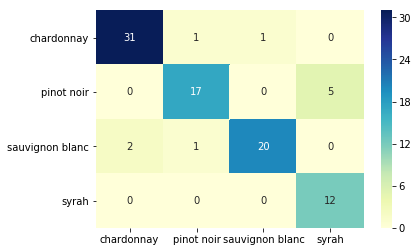

In [102]:
print_stats(y_test, preds, clf_opt.classes_)

Our accuracy increased from 74% to 89%. We can see that the number of false positives and negatives has dropped a lot. Precision, recall and the f1-score are all close to 0.90. The cross wine colour misclassification has decreased too. This is a great improvement.

<a id="ch4"></a>
# 4. Classification of data from Kaggle

As we have already meantioned we came accross a [Kaggle](https://www.kaggle.com/) [Wine Reviews](https://www.kaggle.com/zynicide/wine-reviews) [[5](#ch7)] wine description database by *zackthoutt*. It is much larger than the database we constructed and comes from completely different source. Therefore, verifying if our classification process works even on this database would be an ideal out of sample test. 

We will do 3 things. First, we apply the whole procedure we developed earlier on this database and hope to have good results. Second, we will use the Kaggle database as the train set to fit our model (since this is the larger set) and use our database as the test set. This would be a cross database check of our model which if it works proves the validity of the model. Finally, since the Kaggle database is huge we are not restricted to select only 4 or 5 grape types to classify. We will enlarge our target features, but not to the whole database. 

First, we load the database and transform the relevant columns into the format we used earlier. Also notice, that this database has no explicit information on the body and the colour of the wine, therefore we will only use the description column. Plus, from literature we can add manually the colour of the wine, completing the input information. 

We will not go through such a rigorous pre-processing of the description column as for our own database. We will accept it as it is (and drop any row with NAs). We pre-process the grape variety column with taking its lower case turning any shiraz into syrah.

In [136]:
filename = '../DataBase/winemag-data-130k-v2.csv'

# select the description and grape variety columns
kaggle = pd.read_csv(filename, usecols=['description', 'grape_variety'])
# transform the grape variety column into lower case strings
kaggle['grape_variety'] = kaggle['grape_variety'].str.lower()
kaggle.head()

,description,grape_variety
0,"Aromas include tropical fruit, broom, brimston...",white blend
1,"This is ripe and fruity, a wine that is smooth...",portuguese red
2,"Tart and snappy, the flavors of lime flesh and...",pinot gris
3,"Pineapple rind, lemon pith and orange blossom ...",riesling
4,"Much like the regular bottling from 2012, this...",pinot noir


<a id="ch4.1"></a>
## 4.1. Data formatting

Below you can see a few steps of preprocessing.

In [137]:
# function to change any shiraz into syrah
def shiraz_filter(ss):
    if ss == 'shiraz':
        return 'syrah'
    else:
        return ss

In [138]:
kaggle['grape_variety'] = kaggle.apply(lambda row: shiraz_filter(row['grape_variety']), axis=1)

In [139]:
# drop any row that contains NAs
kaggle = kaggle.dropna()

In [140]:
# select the rows that contains the 4 grape names: chardonnay, syrah, pinot noir, sauvignon blanc
kaggle_input = kaggle[kaggle['grape_variety'].isin(varieties)].reset_index()
pd.unique(kaggle_input.grape_variety)

array(['pinot noir', 'chardonnay', 'sauvignon blanc', 'syrah'],
      dtype=object)

In [141]:
# define a colour dictionary that will be mapped into the databaes
colour_dict = {'pinot noir': 'red', 'syrah': 'red', 'chardonnay': 'white', 'sauvignon blanc': 'white'}

In [142]:
kaggle_input['colour'] = kaggle_input.apply(lambda row: colour_dict[row['grape_variety']], axis=1)
colour_dummies = pd.get_dummies(kaggle_input['colour'])
kaggle_input = kaggle_input.merge(colour_dummies, left_index=True, right_index=True)

Create the train and test sets.

In [143]:
# split the data into train and test
combined_features = ['description', 'white', 'red']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(kaggle_input[combined_features], kaggle_input[target], 
                                                    test_size=0.33, random_state=42)

<a id="ch4.2"></a>
## 4.2. Classification

Let us create the corresponding pipeline:

In [145]:
red = Pipeline([
                ('selector', NumberSelector(key='red')),
                ])
white = Pipeline([
                ('selector', NumberSelector(key='white')),
                ])

In [146]:
text = Pipeline([
                ('selector', TextSelector(key='description')),
                ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words, analyzer='word', 
                                               norm='l2', tokenizer=LemmaTokenizer()))
                ])

In [147]:
feats = FeatureUnion([('description', text),
                      ('red', red),
                      ('white', white)
                      ])

In [ ]:
# classifier and pipeline definition
clf = RandomForestClassifier(random_state=42)
pipe = Pipeline([('feats', feats),
                 ('clf',clf)
                 ])

# definition of parameter grid to scan through
param_grid = {
    #'clf__max_depth': [60, 100, 140],
    'clf__max_features': ['log2', 'auto', None],
    #'clf__min_samples_leaf': [5,10,50,100,200],
    'clf__n_estimators': [100, 500, 1000]
}

# grid search cross validation instantiation
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)

#hyperparameter fitting
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.cv_results_['mean_test_score']

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy = 0.843
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.97      0.78      0.86      4883
     pinot noir       0.90      0.88      0.89      4541
sauvignon blanc       0.59      0.91      0.72      1085
          syrah       0.62      0.91      0.74      1139

    avg / total       0.88      0.84      0.85     11648

----------------------------------------
Confusion matrix


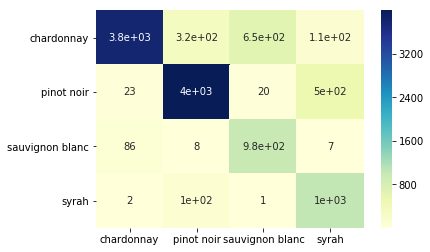

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy = 0.838
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.97      0.78      0.86      4881
     pinot noir       0.90      0.88      0.89      4526
sauvignon blanc       0.59      0.89      0.71      1094
          syrah       0.62      0.90      0.74      1147

    avg / total       0.87      0.84      0.84     11648

----------------------------------------
Confusion matrix


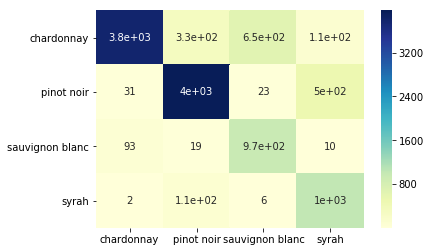

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy = 0.832
----------------------------------------
Classification report:
                 precision    recall  f1-score   support

     chardonnay       0.97      0.76      0.85      4984
     pinot noir       0.88      0.88      0.88      4440
sauvignon blanc       0.57      0.89      0.70      1069
          syrah       0.63      0.90      0.74      1154

    avg / total       0.87      0.83      0.84     11647

----------------------------------------
Confusion matrix


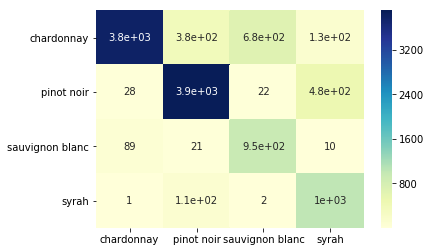

Mean: 0.8376211023975738


In [49]:
### stratified training
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
sc_mean=[]
for train, test in skf.split(kaggle_input[combined_features], kaggle_input[target]):
    pipe.fit(kaggle_input.loc[train,combined_features], kaggle_input.loc[train, target])
    preds = pipe.predict(kaggle_input.loc[test,combined_features])
    sc_mean.append(metrics.accuracy_score(kaggle_input.loc[test, target], preds))
    print_stats(kaggle_input.loc[test, target], preds, pipe.classes_)
    
print('Mean: %s' % str(sum(sc_mean)/len(sc_mean)))
    

<a id="ch5"></a>
# 5. Cross-data validation of the model

In [43]:
# split the data into train and test
combined_features = ['description', 'white', 'red']
target = 'grape_variety'

X_train, X_test, y_train, y_test = train_test_split(kaggle_input[combined_features], kaggle_input[target], 
                                                    test_size=0.33, random_state=42)

In [44]:
red = Pipeline([
                ('selector', NumberSelector(key='red')),
                ])
white = Pipeline([
                ('selector', NumberSelector(key='white')),
                ])


In [45]:
text = Pipeline([
                ('selector', TextSelector(key='description')),
                ('vectorizer', TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words, analyzer='word', 
                                               norm='l2', tokenizer=LemmaTokenizer()))
                ])

In [46]:
feats = FeatureUnion([('description', text),
                      ('red', red),
                      ('white', white)
                      ])


In [47]:
pipe = Pipeline([('feats', feats),
                 ('clf',RandomForestClassifier(random_state=42))
                 ])
    
pipe.fit(X_train, y_train)


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Pipeline(steps=[('feats', FeatureUnion(n_jobs=1,
       transformer_list=[('description', Pipeline(steps=[('selector', TextSelector(key='description')), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',...stimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

In [43]:
# test stats
preds = pipe.predict(data_input[['description']])
print(metrics.accuracy_score(data_input['grape_variety'], preds))
print(metrics.classification_report(data_input['grape_variety'], preds))
print(metrics.confusion_matrix(data_input['grape_variety'], preds))
print(nltk.Counter(data_input['grape_variety']))


0.725925925925926
                 precision    recall  f1-score   support

     chardonnay       0.71      0.95      0.81        91
     pinot noir       0.64      0.92      0.76        59
sauvignon blanc       0.89      0.54      0.67        76
          syrah       0.79      0.34      0.48        44

    avg / total       0.76      0.73      0.71       270

[[86  1  4  0]
 [ 1 54  0  4]
 [32  3 41  0]
 [ 2 26  1 15]]
Counter({'chardonnay': 91, 'sauvignon blanc': 76, 'pinot noir': 59, 'syrah': 44})


In [41]:
colour_dummies = pd.get_dummies(kaggle_input['colour'])
kaggle_input = kaggle_input.merge(colour_dummies, left_index=True, right_index=True)


In [49]:
# test stats
preds = pipe.predict(X_test)
print(metrics.accuracy_score(y_test, preds))
print(metrics.classification_report(y_test, preds))
print(metrics.confusion_matrix(y_test, preds))
print(nltk.Counter(y_test))


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.866718695802983
                 precision    recall  f1-score   support

     chardonnay       0.85      0.98      0.91      3822
     pinot noir       0.86      0.98      0.92      4378
sauvignon blanc       0.92      0.59      0.72      1635
          syrah       0.93      0.59      0.72      1697

    avg / total       0.87      0.87      0.86     11532

[[3735    1   86    0]
 [   4 4296    1   77]
 [ 669    0  966    0]
 [   1  698    0  998]]
Counter({'pinot noir': 4378, 'chardonnay': 3822, 'syrah': 1697, 'sauvignon blanc': 1635})


In [50]:
### stratified training
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3)
sc_mean=[]
for train, test in skf.split(kaggle_input[combined_features], kaggle_input[target]):
    pipe.fit(kaggle_input.loc[train,combined_features], kaggle_input.loc[train, target])
    preds = pipe.predict(kaggle_input.loc[test,combined_features])
    sc_mean.append(metrics.accuracy_score(kaggle_input.loc[test, target], preds))
    
    print(metrics.accuracy_score(kaggle_input.loc[test, target], preds))
    print(metrics.classification_report(kaggle_input.loc[test, target], preds))
    print(metrics.confusion_matrix(kaggle_input.loc[test, target], preds))
    print(nltk.Counter(kaggle_input.loc[test, target]))
print('Mean: %s' % str(sum(sc_mean)/len(sc_mean)))
    

C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.8668440934065934
                 precision    recall  f1-score   support

     chardonnay       0.85      0.97      0.91      3914
     pinot noir       0.87      0.98      0.92      4421
sauvignon blanc       0.89      0.61      0.72      1655
          syrah       0.90      0.60      0.72      1658

    avg / total       0.87      0.87      0.86     11648

[[3793    1  120    0]
 [   4 4312    1  104]
 [ 651    0 1004    0]
 [   2  668    0  988]]
Counter({'pinot noir': 4421, 'chardonnay': 3914, 'syrah': 1658, 'sauvignon blanc': 1655})


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.8638392857142857
                 precision    recall  f1-score   support

     chardonnay       0.85      0.97      0.91      3914
     pinot noir       0.86      0.98      0.92      4421
sauvignon blanc       0.91      0.58      0.71      1655
          syrah       0.90      0.59      0.71      1658

    avg / total       0.87      0.86      0.85     11648

[[3813    3   98    0]
 [   3 4312    0  106]
 [ 690    1  963    1]
 [   0  684    0  974]]
Counter({'pinot noir': 4421, 'chardonnay': 3914, 'syrah': 1658, 'sauvignon blanc': 1655})


C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


0.8676053919464239
                 precision    recall  f1-score   support

     chardonnay       0.84      0.97      0.90      3914
     pinot noir       0.87      0.98      0.92      4421
sauvignon blanc       0.90      0.58      0.71      1654
          syrah       0.92      0.62      0.74      1658

    avg / total       0.87      0.87      0.86     11647

[[3803    4  107    0]
 [   7 4319    2   93]
 [ 691    1  962    0]
 [   5  630    2 1021]]
Counter({'pinot noir': 4421, 'chardonnay': 3914, 'syrah': 1658, 'sauvignon blanc': 1654})
Mean: 0.8660962570224343


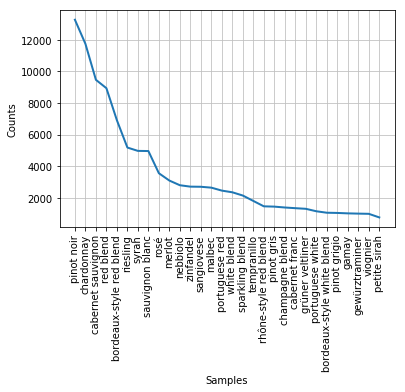

In [115]:
count = nltk.FreqDist(kaggle.grape_variety)
count.plot(30)

<a id="ch6"></a>
# 6. Conclusion

Do not be impatient... Updates are coming soon to this page. In the meanwhile please feel free to contact me at [diveki@gmail.com](diveki@gmail.com). You can also fork this project from [my GitHub repository](https://github.com/diveki/WineSommelier) or you can take a sneaky look at [my GitHub Pages website](https://diveki.github.io).

Just as a bonus, the prelude for this report can be found [here](https://diveki.github.io/projects/wine.html).

<a id="ch7"></a>
# 7. References
1. https://en.wikipedia.org/wiki/Sommelier
2. Wine and Spirit Education Trust - https://www.wsetglobal.com/
3. Wine terminology list - https://www.cawineclub.com/wine-tasting-terms
4. Become a sommelier - https://diveki.github.io/projects/wine/wine.html
5. Kagge Wine Review - https://www.kaggle.com/zynicide/wine-reviews
6. Application of TfIdf-vectorizer on wine data - https://diveki.github.io/projects/wine/tfidf.html
7. Lemmatization - https://en.wikipedia.org/wiki/Lemmatisation
8. Label encoding - https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621